In [85]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from collections import Counter
from skmultilearn.dataset import load_dataset
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

# We import seaborn to make nice plots. 
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


def line(marker='-', n = 30):
    print(marker*n)

## Part A — Preprocessing and initial setup

This section loads the ARFF file, inspects dimensions, and constructs the coloring scheme requested (two most frequent single labels, one common multi-label, and "Other").

In [86]:
# setting plot-style
# sns.set_style('whitegrid')

# Load the Yeast dataset. This function automatically handles the ARFF format
# and returns the feature matrix (X) and the label matrix (Y).

X, Y, feature_names, label_names = load_dataset('yeast', 'undivided')

# Convert from sparse matrix format to a dense numpy array for easier manipulation
X = X.toarray()
Y = Y.toarray()


# Report the initial shapes of the feature and label matrices
print('Feature names: ', [f[0] for f in feature_names])
print('Lable names: ', [l[0] for l in label_names])
print(f"Feature matrix (X) shape: {X.shape}")
print(f"Label matrix (Y) shape: {Y.shape}")

yeast:undivided - exists, not redownloading
Feature names:  ['Att1', 'Att2', 'Att3', 'Att4', 'Att5', 'Att6', 'Att7', 'Att8', 'Att9', 'Att10', 'Att11', 'Att12', 'Att13', 'Att14', 'Att15', 'Att16', 'Att17', 'Att18', 'Att19', 'Att20', 'Att21', 'Att22', 'Att23', 'Att24', 'Att25', 'Att26', 'Att27', 'Att28', 'Att29', 'Att30', 'Att31', 'Att32', 'Att33', 'Att34', 'Att35', 'Att36', 'Att37', 'Att38', 'Att39', 'Att40', 'Att41', 'Att42', 'Att43', 'Att44', 'Att45', 'Att46', 'Att47', 'Att48', 'Att49', 'Att50', 'Att51', 'Att52', 'Att53', 'Att54', 'Att55', 'Att56', 'Att57', 'Att58', 'Att59', 'Att60', 'Att61', 'Att62', 'Att63', 'Att64', 'Att65', 'Att66', 'Att67', 'Att68', 'Att69', 'Att70', 'Att71', 'Att72', 'Att73', 'Att74', 'Att75', 'Att76', 'Att77', 'Att78', 'Att79', 'Att80', 'Att81', 'Att82', 'Att83', 'Att84', 'Att85', 'Att86', 'Att87', 'Att88', 'Att89', 'Att90', 'Att91', 'Att92', 'Att93', 'Att94', 'Att95', 'Att96', 'Att97', 'Att98', 'Att99', 'Att100', 'Att101', 'Att102', 'Att103']
Lable names:  ['C

In [87]:
from collections import Counter

n_samples = Y.shape[0]
label_counts = Y.sum(axis=1)
print("Multilabelled frequencies: ")
d = dict(Counter(label_counts))
print(d)
print()

single_label_idxs = np.where(label_counts==1)[0]

Y_single = Y[single_label_idxs]
print("Single labelled data distribution among 14 classes: ", Y_single.sum(axis=0))
line()

single_labels = []
for i in single_label_idxs:
    lab = np.where(Y[i]==1)[0]
    if len(lab)==1:
        single_labels.append(lab[0])

single_counter = Counter(single_labels)

most_common_two = [lab for lab, _ in single_counter.most_common(2)]

if len(most_common_two) > 1:
    lst = [label_names[i][0] for i in most_common_two]
    print("Two most frequent single-label classes (indices):", most_common_two)
else: 
    lst = [label_names[i][0] for i in most_common_two]
    print('Only one most frequent single-label class exists: ', lst)


combos = [tuple(row) for row in Y.tolist()]
combo_counter = Counter(combos)
multi_combo = None
for combo, cnt in combo_counter.most_common():
    if sum(combo) > 1:
        multi_combo = combo
        break
print('Most frequent multi-label combination (as binary tuple):', multi_combo)
line()


cat = np.full(n_samples, 3, dtype=int)
if most_common_two:
    cat[np.where((label_counts==1) & (np.argmax(Y, axis=1)==most_common_two[0]))] = 0
if len(most_common_two) > 1:
    cat[np.where((label_counts==1) & (np.argmax(Y, axis=1)==most_common_two[1]))] = 1

if multi_combo is not None:
    mask_multi = np.array([tuple(row)==multi_combo for row in Y.tolist()])
    cat[mask_multi] = 2

cat_names = {0: f'Single-label-{most_common_two[0]}' if most_common_two else 'Single-1',
             1: f'Single-label-{most_common_two[1]}' if len(most_common_two)>1 else 'Single-2',
             2: 'Most-freq-multi-label' if multi_combo is not None else 'Multi-None',
             3: 'Other'}

print("Distribution of new categories for visualization: ")

d = Counter(cat)
for k, v in dict(d).items():
    print(cat_names[k], "\t", v)
line()
print('Category names mapping:', cat_names)

Multilabelled frequencies: 
{4: 1102, 2: 412, 3: 112, 5: 173, 7: 102, 6: 415, 8: 55, 1: 32, 9: 9, 10: 4, 11: 1}

Single labelled data distribution among 14 classes:  [32  0  0  0  0  0  0  0  0  0  0  0  0  0]
------------------------------
Only one most frequent single-label class exists:  ['Class1']
Most frequent multi-label combination (as binary tuple): (0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)
------------------------------
Distribution of new categories for visualization: 
Other 	 2148
Most-freq-multi-label 	 237
Single-label-0 	 32
------------------------------
Category names mapping: {0: 'Single-label-0', 1: 'Single-2', 2: 'Most-freq-multi-label', 3: 'Other'}


### Scaling

**Why scale?** Distance-based methods like t-SNE and Isomap rely on distance computations. If features have different scales, features with larger ranges will dominate distance calculations, skewing neighbourhood relationships and the resulting embedding. Standardization (zero mean, unit variance) puts all features on the same scale and often improves these methods' performance.

We apply `StandardScaler` to the feature matrix.

In [88]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Scaled X mean (per-feature) first five:', np.round(X_scaled.mean(axis=0)[:5],3))
print('Scaled X std (per-feature) first five:', np.round(X_scaled.std(axis=0)[:5],3))

Scaled X mean (per-feature) first five: [ 0.  0. -0. -0.  0.]
Scaled X std (per-feature) first five: [1. 1. 1. 1. 1.]


## Part B: t-SNE and Veracity Inspection

Now that our data is prepared, we will use **t-Distributed Stochastic Neighbor Embedding (t-SNE)** to reduce the 103-dimensional feature space into a 2-dimensional map that we can visualize. t-SNE is a powerful technique particularly well-suited for revealing the underlying **local structure** of data, showing how data points group together in their high-dimensional neighborhoods.

### 1. t-SNE Implementation and the `perplexity` Hyperparameter

A crucial hyperparameter for t-SNE is `perplexity`. In simple terms, perplexity can be thought of as a guess about the number of close neighbors each point has. It influences how the algorithm balances local and global aspects of the data structure.

* A **low perplexity** value (e.g., 5) makes the algorithm focus on the smallest local details, which can sometimes result in tight, separated clusters that might overstate the true separation.
* A **high perplexity** value (e.g., 50) considers a larger number of neighbors for each point, which can help reveal more of the data's global structure but might obscure fine-grained clusters.

As instructed, we will experiment with several perplexity values (`5`, `30`, `50`) to observe how the visualization changes and to select the most informative one for our final analysis.

In [101]:
def run_tsne(X, perplexity=30, random_state=42):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, init='pca', learning_rate='auto')
    Z = tsne.fit_transform(X)
    return Z

# perps = [5, 10, 20, 25, 30, 35, 40, 50]
perps = [5, 30, 50, 100]
tsne_results = {}
for p in perps:
    print('Running t-SNE with perplexity =', p)
    tsne_results[p] = run_tsne(X_scaled, perplexity=p)


Running t-SNE with perplexity = 5
Running t-SNE with perplexity = 30
Running t-SNE with perplexity = 50
Running t-SNE with perplexity = 100


### 2. Final t-SNE Visualization

After experimenting, we will select the best perplexity value and generate a final, full-sized scatter plot. This plot will be colored according to the four categories we created in Part A (`class_1`, `class_2`, `Top Multi-Label Combo`, and `Other`) to help us interpret the clusters.

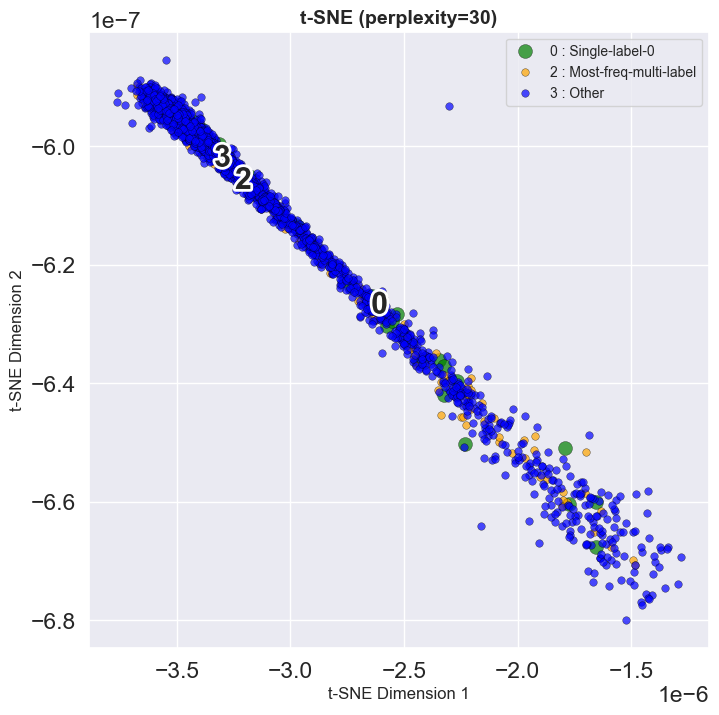

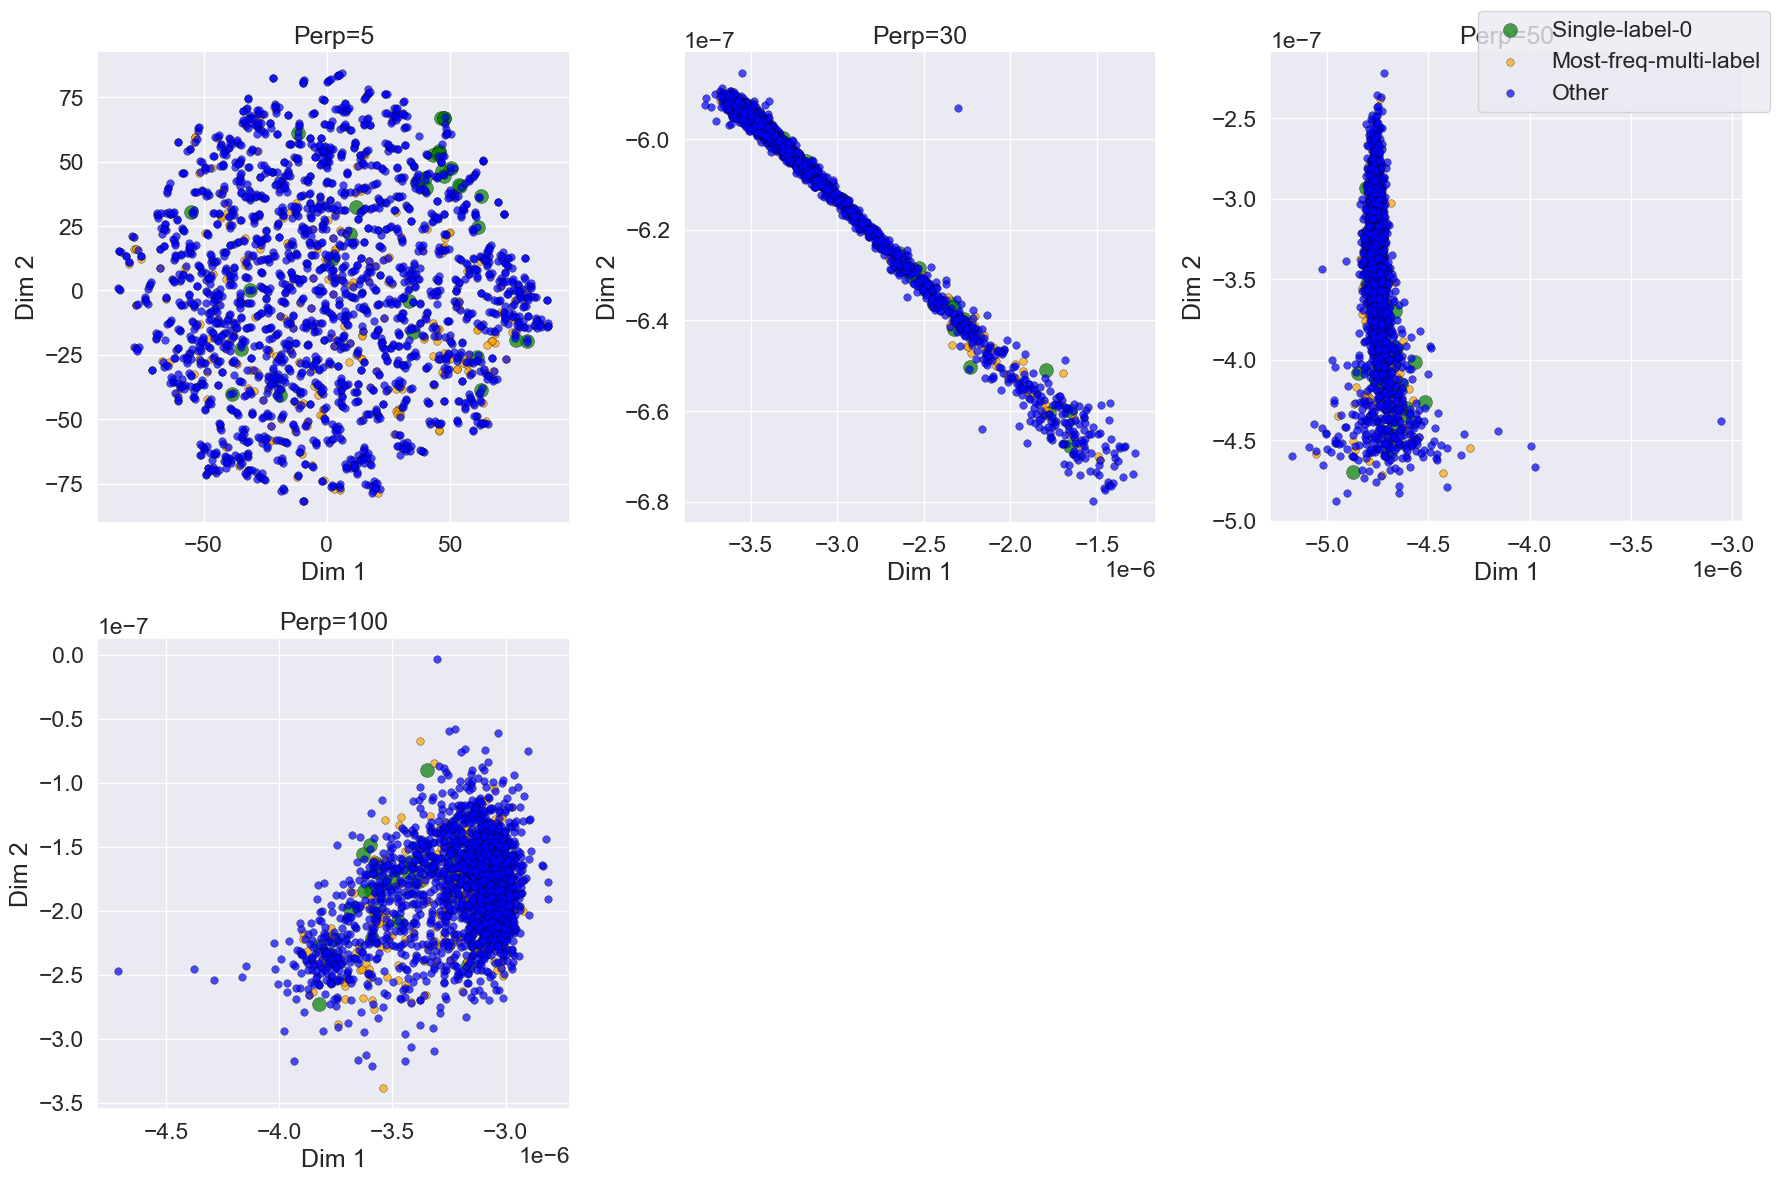

In [95]:
# Fixed custom color map
fixed_colors = {
    0: "green",   # Single-label
    1: "orange",  # (if another single exists, or unused in your case)
    2: "orange",  # Multi-label (most frequent combo)
    3: "blue"     # Other
}

# ---- Function 1: Single scatter plot ----
import matplotlib.patheffects as PathEffects


def scatter(coords, categories, cat_names,  fixed_colors, markersize=30, title="t-SNE embedding"):
    """
    Create a scatter plot for yeast t-SNE embedding with category labels and legend.
    
    coords      : 2D array of shape (n_samples, 2)
    categories  : 1D array of categorical indices (0,1,2,3,...)
    cat_names   : dict mapping category index -> name
    fixed_colors: dict mapping category index -> color string
    title       : str, title for the plot
    """
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    # Plot points for each category
    for c in np.unique(categories):
        mask = categories == c
        ax.scatter(coords[mask,0], coords[mask,1], 
                   lw=0, s=100 if c == 0 else markersize, 
                   color=fixed_colors.get(int(c), "gray"), 
                   label=str(c)+ " : " + cat_names.get(int(c), str(c)), 
                   alpha=0.7, edgecolor='k', linewidth=0.3)

    # Add labels at cluster median
    txts = []
    for c in np.unique(categories):
        xtext, ytext = np.median(coords[categories == c, :], axis=0)
        txt = ax.text(xtext, ytext, str(c), 
                      fontsize=22, weight='bold',
                      ha='center', va='center')
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=4, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    # Formatting
    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.legend(loc="best", fontsize=10, frameon=True)
    ax.axis('tight')

    return f, ax, txts


# ---- Function 2: Subplot for multiple embeddings ----
def plot_2d_subplots(results_dict, categories, cat_names, 
                     ncols=3, figsize=(15,10), markersize=30, fixed_colors=None):
    """
    Plot multiple 2D embeddings in a grid of subplots (fixed palette).
    """
    import math
    n = len(results_dict)
    nrows = math.ceil(n / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    
    for ax, (label, coords) in zip(axes.flat, results_dict.items()):
        for c in np.unique(categories):
            mask = categories == c
            color = fixed_colors.get(int(c), "gray") if fixed_colors else None
            ax.scatter(coords[mask,0], coords[mask,1],
                       s=100 if c == 0 else markersize,
                       color=color,
                       label=cat_names.get(int(c), str(c)), 
                       alpha=0.7, edgecolor='k', linewidth=0.3)
        ax.set_title(str(label))
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
    
    # Hide unused subplots if any
    for ax in axes.flat[n:]:
        ax.set_visible(False)
    
    # Shared legend
    handles, labels = axes.flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    
    plt.tight_layout()
    plt.show()


# Single plot example
scatter(tsne_results[30], cat, cat_names, 
               title="t-SNE (perplexity=30)", fixed_colors=fixed_colors)

# Side-by-side plots with fixed colors
plot_2d_subplots(
    {f"Perp={p}": tsne_results[p] for p in perps}, 
    cat, cat_names, 
    ncols=3, figsize=(18,12), fixed_colors=fixed_colors
)

### 3. Veracity Inspection

The main goal of this visualization is to identify potential data quality issues. We will analyze the final t-SNE plot to visually identify regions that correspond to:

1.  **Noisy/Ambiguous Labels:** Points from one category that are deeply embedded within a cluster of another color.
2.  **Outliers:** Isolated points or very small, distant clusters that may represent experiments with unusual gene expression profiles.
3.  **Hard-to-Learn Samples:** Areas where the colors are heavily mixed, indicating that the feature vectors for different functional categories are very similar in these regions, making them difficult for a classifier to distinguish.

# Part C:  Isomap and Manifold Learning 

### 1. Isomap Implementation
### Fundamental Difference Between Isomap & t-SNE

Both **Isomap** and **t-SNE** are non-linear dimensionality reduction techniques, but they preserve
different aspects of the data structure:

---

#### Isomap: Preserves **Global Structure**
- **Idea:** Isomap builds a *neighborhood graph* of the data and estimates **geodesic distances**
  (shortest paths along the manifold, not straight-line Euclidean distances).
- Then, it applies classical **Multidimensional Scaling (MDS)** to preserve these geodesic distances
  in a lower-dimensional space.
- **Effect:** The embedding maintains **large-scale geometry** of the dataset — how clusters and
  regions relate globally.
- Example: If the data lies on a curved "Swiss roll" manifold, Isomap will **unroll** it smoothly,
  showing the overall global structure.

---

#### t-SNE: Preserves **Local Structure**
- **Idea:** t-SNE converts pairwise distances into probabilities that represent **local similarities**
  between points. It then finds a low-dimensional embedding where these similarities are preserved.
- The algorithm focuses on keeping **nearby points close together** while allowing global distances
  to be distorted.
- **Effect:** The embedding emphasizes **clusters** and local neighborhoods, but the distance between
  clusters is not necessarily meaningful.
- Example: t-SNE may separate distinct groups of points clearly, but their relative positions may be
  arbitrary (clusters could be closer/farther without reflecting true global geometry).

---

#### Summary
- **Isomap = Global preservation** → Good for understanding the *overall shape* of the data manifold
  and continuous structures.
- **t-SNE = Local preservation** → Good for discovering *clusters* and fine-grained local patterns,
  but less reliable for global relationships.
- In practice, both methods are complementary:  
  - Use **t-SNE** to find and visualize local clusters of similar samples.  
  - Use **Isomap** to understand the broader manifold and how clusters connect globally.


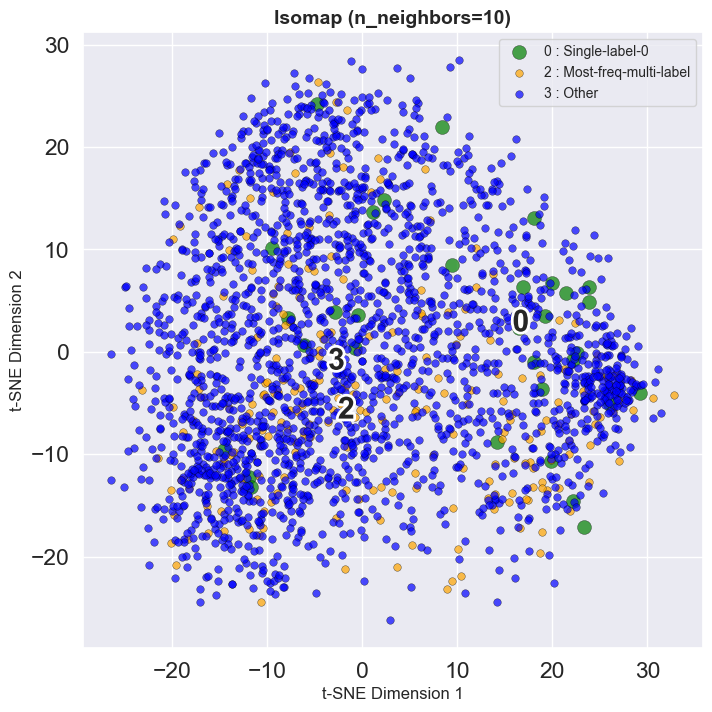

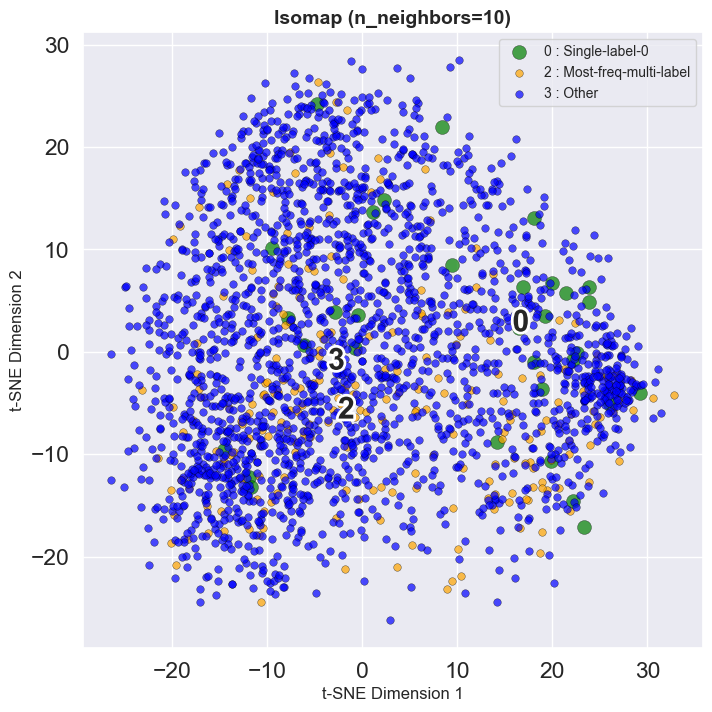

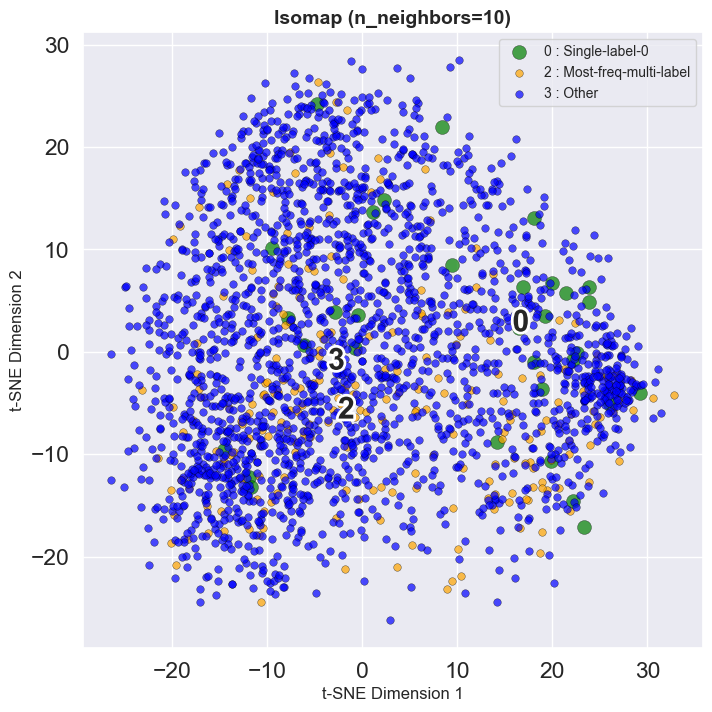

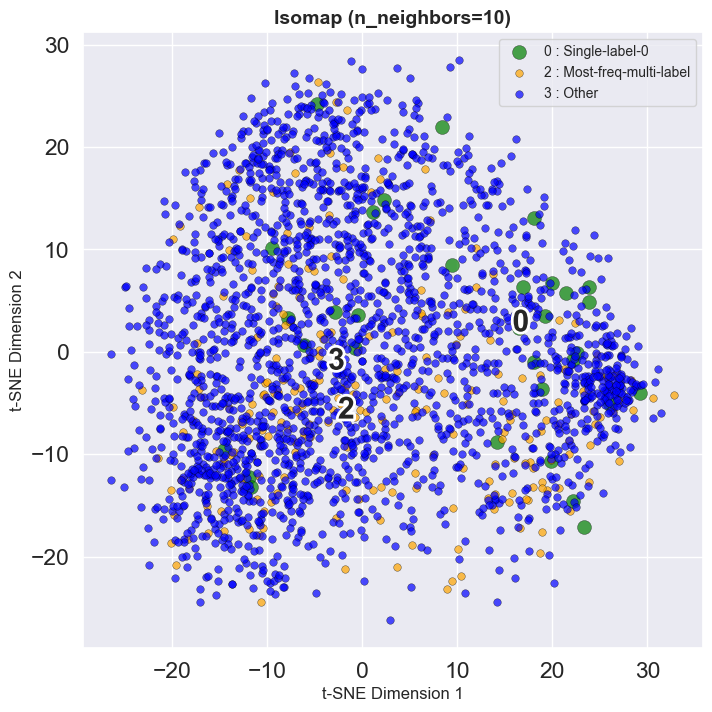

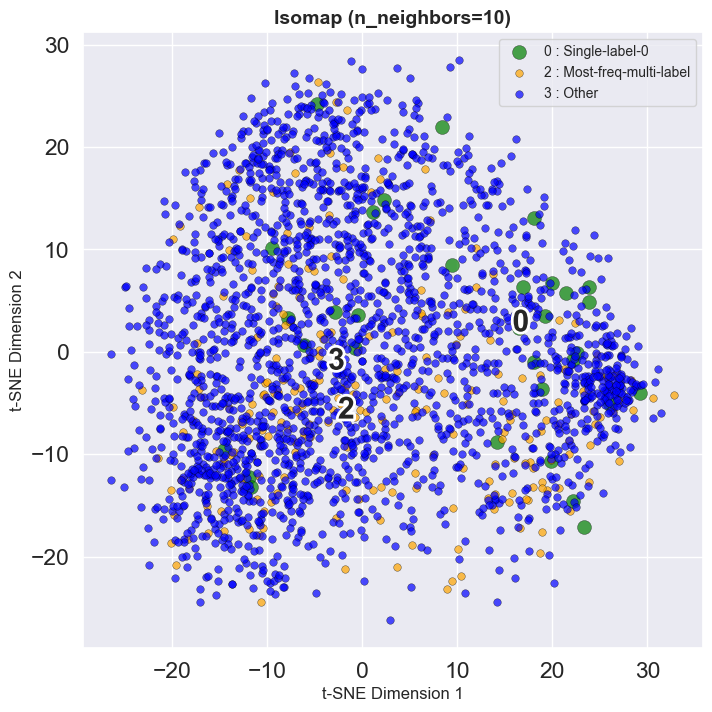

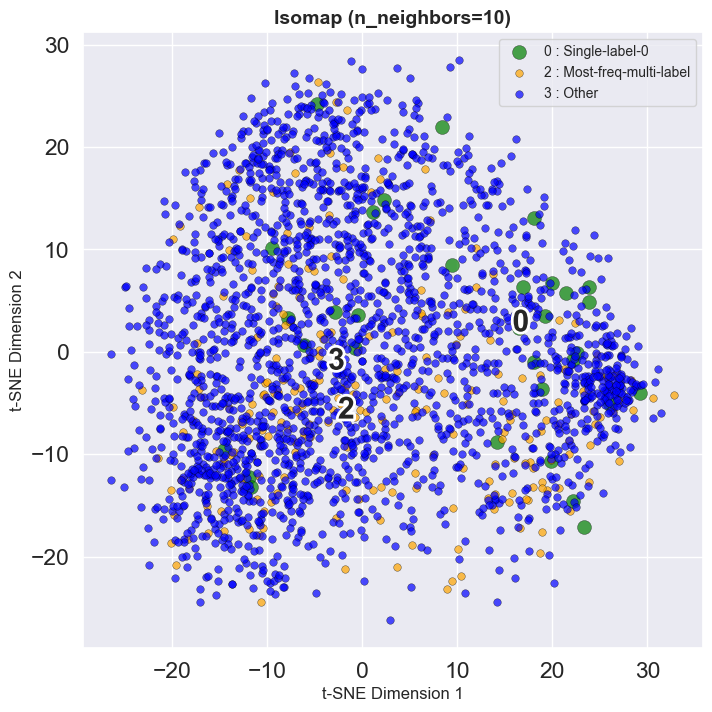

In [100]:
for n in [5, 10, 15, 20, 30, 50]:
    isomap = Isomap(n_components=2, n_neighbors=5)
    Z_iso = isomap.fit_transform(X_scaled)
    scatter(Z_iso, cat, cat_names, title='Isomap (n_neighbors=10)', fixed_colors=fixed_colors)
    plt.show()